# Spatial regression

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
from scipy.stats import spearmanr
import json
import pickle
from scipy.stats import norm
from sklearn.metrics import mean_absolute_percentage_error
from scipy.spatial.distance import cdist
import wasserstein
from matplotlib.lines import Line2D
from datetime import datetime
from collections import defaultdict
import torch
import warnings
from collections import Counter
from scipy.stats import pearsonr
warnings.filterwarnings("ignore")
plt.rcParams.update({"font.size":15})

### Model comparison with OT, MSE and residual Moran's I

In [2]:
out_path = os.path.join("..", "outputs", "spatial_regression") # "/Users/ninawiedemann/MIE/z_inactive_projects/spatial_random_forest/geot_outputs_cv"
for dataset in [
    "atlantic",
    "deforestation",
]:
    print("=========", dataset)
    results = pd.read_csv(os.path.join(out_path, f"results_{dataset}.csv"), index_col="Method")

    r, p = pearsonr(results["ot_loss_0"], results["moransi_2"])
    print("Correlation of OT (0) with Moran's I 3-KNN", r)

    r, p = pearsonr(results["ot_loss_0"], results["moransi_cost"])
    print("Correlation of OT (0) with Moran's I (cost)", r)

    for c in results.columns:
        if "ot_loss" in c:
            results[c] = (results[c]/1000000).round().astype(int).astype(str) + "k km"
    results[r"OT error ($\phi$ low)"] = results["ot_loss_low"]    
    results[r"OT error ($\phi$ high)"] = results["ot_loss_max"]
    results["Moran's I (3-NN)"] = results["moransi_2"].round(3)
    results["Moran's I (-C)"] = results["moransi_cost"].round(3)
    results["RMSE"] = results["RMSE"].round(3)    
    results["R-Squared"] = results["R-Squared"].round(3)
    results.rename({"RF (coordinates)": "RF", "linear regression": "LR"}, inplace=True)
    
    table_final = results[["RMSE", "R-Squared", "Moran's I (3-NN)", "Moran's I (-C)", r"OT error ($\phi$ low)", r"OT error ($\phi$ high)"]].sort_values("RMSE")
    display(table_final) 
    print(table_final.to_latex(escape=False))

========= atlantic
Correlation of OT (0) with Moran's I 3-KNN 0.672591092435622
Correlation of OT (0) with Moran's I (cost) 0.44719704596166154


,RMSE,R-Squared,Moran's I (3-NN),Moran's I (-C),OT error ($\phi$ low),OT error ($\phi$ high)
Method,,,,,,
GWR,7.099,0.654,0.052,0.010,128k km,320k km
RF,7.278,0.636,0.036,0.006,124k km,258k km
LR,8.632,0.488,0.390,0.098,295k km,315k km
SLX,8.639,0.487,0.378,0.097,293k km,309k km
SAR,9.086,0.433,0.382,-2.039,433k km,3510k km


\begin{tabular}{lrrrrll}
\toprule
{} &   RMSE &  R-Squared &  Moran's I (3-NN) &  Moran's I (-C) & OT error ($\phi$ low) & OT error ($\phi$ high) \\
Method &        &            &                   &                 &                       &                        \\
\midrule
GWR    &  7.099 &      0.654 &             0.052 &           0.010 &               128k km &                320k km \\
RF     &  7.278 &      0.636 &             0.036 &           0.006 &               124k km &                258k km \\
LR     &  8.632 &      0.488 &             0.390 &           0.098 &               295k km &                315k km \\
SLX    &  8.639 &      0.487 &             0.378 &           0.097 &               293k km &                309k km \\
SAR    &  9.086 &      0.433 &             0.382 &          -2.039 &               433k km &               3510k km \\
\bottomrule
\end{tabular}

========= deforestation
Correlation of OT (0) with Moran's I 3-KNN 0.6000419666983905
Correlation of 

,RMSE,R-Squared,Moran's I (3-NN),Moran's I (-C),OT error ($\phi$ low),OT error ($\phi$ high)
Method,,,,,,
RF,0.673,0.638,0.068,0.000,4k km,6k km
GWR,0.799,0.489,0.077,-0.000,4k km,12k km
SLX,0.825,0.456,0.210,0.000,6k km,6k km
LR,0.830,0.449,0.237,0.000,7k km,7k km
SAR,0.846,0.428,0.237,-0.008,12k km,83k km


\begin{tabular}{lrrrrll}
\toprule
{} &   RMSE &  R-Squared &  Moran's I (3-NN) &  Moran's I (-C) & OT error ($\phi$ low) & OT error ($\phi$ high) \\
Method &        &            &                   &                 &                       &                        \\
\midrule
RF     &  0.673 &      0.638 &             0.068 &           0.000 &                 4k km &                  6k km \\
GWR    &  0.799 &      0.489 &             0.077 &          -0.000 &                 4k km &                 12k km \\
SLX    &  0.825 &      0.456 &             0.210 &           0.000 &                 6k km &                  6k km \\
LR     &  0.830 &      0.449 &             0.237 &           0.000 &                 7k km &                  7k km \\
SAR    &  0.846 &      0.428 &             0.237 &          -0.008 &                12k km &                 83k km \\
\bottomrule
\end{tabular}



### Unpaired OT with Atlantic dataset

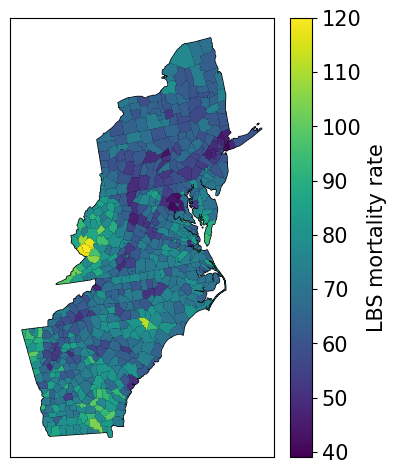

In [3]:
path_pointwise_results = os.path.join(out_path, "atlantic_cv_GWR.pkl")

import pickle
plt.rcParams.update({'font.size': 15})
with open(os.path.join(path_pointwise_results), "rb") as f:
    (test_pred, test_gt, coords) = pickle.load(f)
    
counties = gpd.read_file(os.path.join("..", "data_submission", "spatial_regression", "COUNTY_ATLANTIC.shp"))

residuals_df = pd.DataFrame(coords, columns=["x", "y"])
residuals_df["pred"] = test_pred
residuals_df["gt"] = test_gt
residuals_df["residuals"] = test_pred - test_gt
residuals_df = gpd.GeoDataFrame(residuals_df.merge(counties, left_on = ["x", "y"], right_on=["x", "y"]), geometry="geometry", crs=counties.crs)

fig, ax = plt.subplots(figsize=(4.2,5))
counties.plot(ax=ax, facecolor="white", edgecolor="black")
scatter = residuals_df.plot(column="gt", ax=ax, legend=True, cmap="viridis", legend_kwds={"label": "LBS mortality rate"})
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig("../figures_revision/atlantic_gt.pdf")
plt.show()

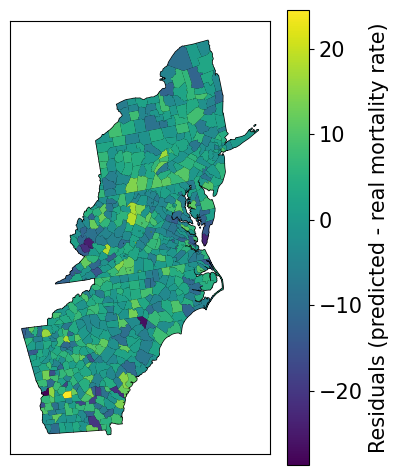

In [4]:
fig, ax = plt.subplots(figsize=(4.2,5))
counties.plot(ax=ax, facecolor="white", edgecolor="black")
scatter = residuals_df.plot(column="residuals", ax=ax, legend=True, cmap="viridis", legend_kwds={"label": "Residuals (predicted - real mortality rate)"})
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

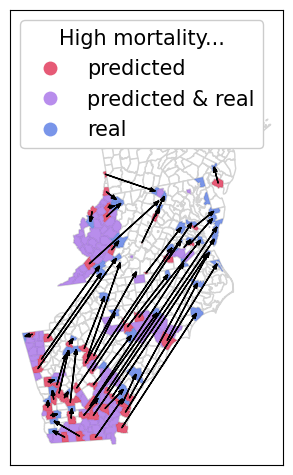

In [5]:
import ot
quant = 0.75
threshold = np.quantile(test_gt, quant)
def check_high(row):
    if row["pred"] > threshold:
        if row["gt"] > threshold:
            return "predicted & real"
        else:
            return "predicted"
    elif row["gt"] > threshold:
        return "real"
    else:
        return pd.NA
            
residuals_df["high mortality"] = residuals_df.apply(check_high, axis=1)

gt_high_mortality = test_gt > np.quantile(test_gt, quant)
pred_high_mortality = test_pred > np.quantile(test_gt, quant)
# print("Sample ratio", gt_high_mortality.sum() / len(test_gt))

coords_gt = coords[gt_high_mortality]
coords_pred = coords[pred_high_mortality]

# # COMPUTE TRANSPORT MATRIX
# length of pred > length of gt
len_diff = len(coords_gt) - len(coords_pred)
assert len_diff > 0
pred_extended = np.concatenate([coords_pred, np.zeros((len_diff, 2))])
a = np.ones(len(coords_gt)) / len(coords_gt)
b = np.ones(len(pred_extended)) / len(pred_extended)
cost_matrix = cdist(pred_extended, coords_gt)
cost_matrix[-len_diff:, :] = 0
transport_matrix = ot.emd(b, a, cost_matrix)

from matplotlib.colors import ListedColormap
# Define the custom colormap
colors = ["#DC143C", "#9B5DE5", "#4169E1"]
cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(4.2,5))
# plot points
# outline.plot(ax=ax, facecolor="white")
residuals_df.plot(ax=ax, facecolor="white", edgecolor="lightgrey")
scatter = residuals_df.plot(column="high mortality", ax=ax, legend=True, cmap=cmap,
                            legend_kwds={"title": "High mortality...", "loc":"upper left", "framealpha": 1}, alpha=0.7 #  "fontsize": 14,
                           ) # , colors=["red", "purple", "blue"])# , cmap="viridis") # , legend_kwds={"label": "Residuals\n(predicted - real mortality rate)"})
# plot arrows
for i, (x1, y1) in enumerate(coords_pred):
    for j, (x2, y2) in enumerate(coords_gt):
        if (i != j) and (transport_matrix[i,j] > 0) and (x1 != x2):
            plt.arrow(x1, y1, x2-x1, y2-y1, head_width=15000, length_includes_head=True, overhang=1, color="black")

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

### Unpaired OT of deforestation dataset

This notebook reproduces the experiment on deforestation data as an example for *unpaired OT*.

In [6]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#### Read data -  deforestation data (taken from https://github.com/FSantosCodes/GWRFC/tree/master/data)

In [7]:
ds = pd.read_csv(os.path.join("..", "data_submission", "spatial_regression", "deforestation.csv"))

In [8]:
label_col = "deforestation_quantile"
inp_data = ds.drop([label_col], axis=1) # , "x", "y"
labels = ds[label_col]

# randomly divide into train and test data
np.random.seed(42)
inds = np.random.permutation(inp_data.index)
len_train = int(len(inp_data) * 0.8)
train_inds, test_inds = inds[:len_train], inds[len_train:]
train_x, train_y, test_x, test_y = inp_data.loc[train_inds], labels.loc[train_inds], inp_data.loc[test_inds], labels.loc[test_inds]

In [9]:
rf = RandomForestClassifier(n_estimators=100)

In [10]:
rf.fit(train_x, train_y)

RandomForestClassifier()

In [11]:
out_pred = rf.predict(test_x)

In [12]:
accuracy_score(out_pred.round(), test_y)

0.5785123966942148

In [13]:
confusion_matrix(test_y, out_pred)

array([[83, 30,  9,  2],
       [26, 45, 33, 10],
       [ 7, 30, 69, 24],
       [ 0, 10, 23, 83]])

In [14]:
print(classification_report(test_y, out_pred))

              precision    recall  f1-score   support

           1       0.72      0.67      0.69       124
           2       0.39      0.39      0.39       114
           3       0.51      0.53      0.52       130
           4       0.70      0.72      0.71       116

    accuracy                           0.58       484
   macro avg       0.58      0.58      0.58       484
weighted avg       0.58      0.58      0.58       484



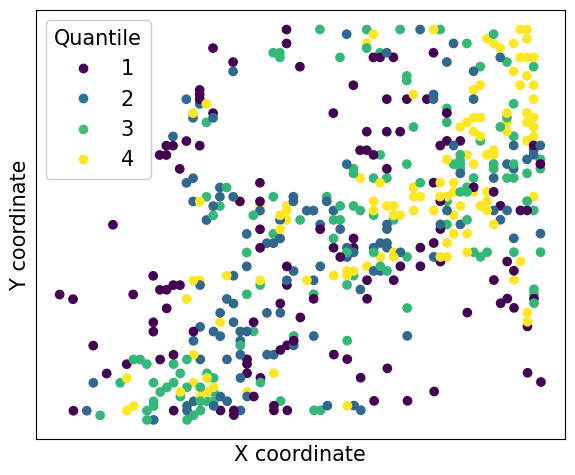

In [15]:
# high deforestation gt vs high deforestation real
plt.figure(figsize=(6,5))
scatter = plt.scatter(inp_data.loc[test_inds, "x"], inp_data.loc[test_inds, "y"], c=labels.loc[test_inds])
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.xticks([])
plt.yticks([])
legend_elements = [Line2D([0], [0], marker='o', markeredgecolor=mpl.colormaps["viridis"](0), markerfacecolor=mpl.colormaps["viridis"](0), markersize=6, label='1', lw=0),
                   Line2D([0], [0], marker='o',  markerfacecolor=mpl.colormaps["viridis"](100), markersize=6, label='2', lw=0),
                  Line2D([0], [0],  marker='o', markeredgecolor=mpl.colormaps["viridis"](180), markerfacecolor=mpl.colormaps["viridis"](180), markersize=6,label='3', lw=0),
                  Line2D([0], [0],  marker='o', markeredgecolor=mpl.colormaps["viridis"](500),  markerfacecolor=mpl.colormaps["viridis"](300), markersize=6, label='4', lw=0)
                  ]
# Create the figure
plt.legend(handles=legend_elements, title="Quantile", loc="upper left", framealpha=1)
# plt.legend()
plt.tight_layout()
# plt.savefig("figures/deforestation_quantiles.pdf")
plt.show()

#### 4th quantile analysis

In [16]:
pred_q4 = test_x.loc[out_pred == 4]
gt_q4 = test_x.loc[test_y == 4]
len(pred_q4), len(gt_q4)

(119, 116)

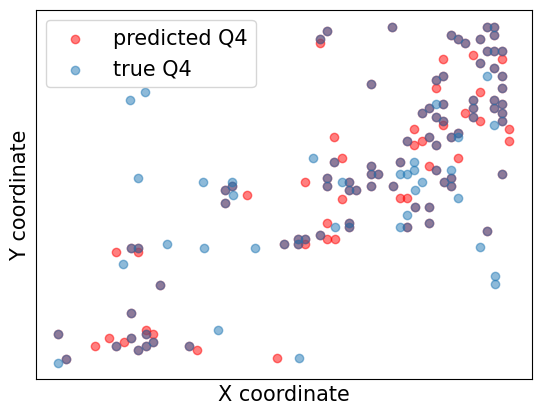

In [17]:
# high deforestation gt vs high deforestation real
plt.scatter(pred_q4["x"], pred_q4["y"], alpha=0.5, label="predicted Q4", c="red")
plt.scatter(gt_q4["x"], gt_q4["y"], alpha=0.5, label="true Q4")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

In [18]:
import ot
import ot.plot

In [19]:
coords_pred_q4 = pred_q4[["x", "y"]].values
coords_gt_q4 = gt_q4[["x", "y"]].values

In [20]:
# length of pred > length of gt
len_diff = len(pred_q4) - len(gt_q4)
assert len_diff > 0
gt_extended = np.concatenate([coords_gt_q4, np.zeros((len_diff, 2))])
a = np.ones(len(coords_pred_q4)) / len(coords_pred_q4)
b = np.ones(len(gt_extended)) / len(gt_extended)
cost_matrix = cdist(coords_pred_q4, gt_extended)
cost_matrix[:, -len_diff:] = 0
transport_matrix = ot.emd(a, b, cost_matrix)

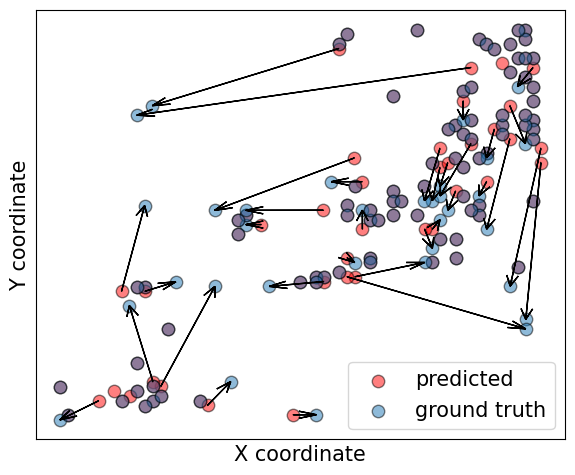

In [21]:
plt.figure(figsize=(6,5))
# plot points
scatter_size = 80
plt.scatter(test_x.loc[out_pred == 4, "x"], test_x.loc[out_pred == 4, "y"], alpha=0.5, label="predicted", c="red", edgecolor="black", s=scatter_size)
plt.scatter(test_x.loc[test_y == 4, "x"], test_x.loc[test_y == 4, "y"], alpha=0.5, label="ground truth", edgecolor="black", s=scatter_size)
# plot arrows
for i, (x1, y1) in enumerate(coords_pred_q4):
    for j, (x2, y2) in enumerate(coords_gt_q4):
        if (i != j) and (transport_matrix[i,j] > 0) and (x1 != x2):
            plt.arrow(x1, y1, x2-x1, y2-y1, head_width=3000, length_includes_head=True, overhang=1)

plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.xticks([])
plt.yticks([])
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig("figures/deforestation.pdf")
plt.show()